# LHIPA with blinks, no stitch
### check headline AOI

In [1]:
import pandas as pd
import numpy as np
import math, pywt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def modmax(d): 
    # compute signal modulus 
    m = [0.0]*len(d) 
    for i in range(len(d)): 
        m[i] = math.fabs(d[i]) 
        
    # if value is larger than both neighbours , and strictly 
    # larger than either, then it is a local maximum 
    t = [0.0]*len(d) 
    for i in range(len(d)): 
        ll = m[i-1] if i >= 1 else m[i] 
        oo = m[i] 
        rr = m[i+1] if i < len(d)-2 else m[i] 
        if (ll <= oo and oo >= rr) and (ll < oo or oo > rr): 
            # compute magnitude 
            t[i] = math.sqrt(d[i]**2) 
        else: 
            t[i] = 0.0 
            
    return t

In [3]:
def lhipa_new(d):
    # find max decomposition level
    w = pywt.Wavelet('sym16')
    maxlevel = pywt.dwt_max_level(len(d[0]),filter_len=w.dec_len)
    # print(maxlevel)
    
    # set high and low frequency band indeces
    hif, lof = 1, int(maxlevel/2)
    
    # get detail coefficients of pupil diameter signal d
    cD_H = pywt.downcoef('d', d[0], 'sym16', 'per', level = hif)
    cD_L = pywt.downcoef('d', d[0], 'sym16', 'per', level = lof)
    
    # normalize by 1/root(2^(j))
    cD_H[:] = [x / math.sqrt(2**hif) for x in cD_H]
    cD_L[:] = [x / math.sqrt(2**lof) for x in cD_L]
    
    # obtain the LH:HF ratio
    cD_LH = cD_L
    for i in range(len(cD_L)):
        cD_LH[i] = cD_L[i] / cD_H[((2**lof)//(2**hif))*i]
        
    # detect modulus maxima, see Duchowski et al.
    cD_LHm = modmax(cD_LH)
    
    # threshold using universal threshold λuniv = σˆ (2 log n)
    # where σˆ is the standard deviation of the noise
    λuniv = np.std(cD_LHm) * math.sqrt(2.0*np.log2(len(cD_LHm))) 
    cD_LHt = pywt.threshold(cD_LHm, λuniv, mode ="less")
    
    # get signal duration (in seconds)
    tt = (d[1][-1] - d[1][0]) / 1000
    
    # compute LHIPA
    ctr = 0
    for i in range(len(cD_LHt)):
        if math.fabs(cD_LHt[i]) > 0: ctr += 1
    LHIPA = float(ctr)/tt
    
    return LHIPA

In [4]:
gaze_df = pd.read_csv('/Volumes/Extreme SSD/research data/good system/database tables/gs_local_gazeWithBlink_pupil_aoi.csv')
gaze_df.head()

,imotion_unix_timestamp,user_id,SourceStimuliName,gaze_AOI,Blink_detected,ET_PupilLeft,ET_PupilRight,ET_ValidityLeft,ET_ValidityRight,Fixation Index
0,1628616621280,P001,A2002,fc_row_5_src_rep,NaN,3.515396,3.655457,0,0,2858.0
1,1628616621284,P001,A2002,fc_row_5_src_rep,0.0,3.511688,3.648514,0,0,2858.0
2,1628616621287,P001,A2002,fc_row_5_src_rep,0.0,3.507050,3.617889,0,0,2858.0
3,1628616621290,P001,A2002,fc_row_5_src_rep,NaN,3.514343,3.643295,0,0,2858.0
4,1628616621294,P001,A2002,fc_row_5_src_rep,0.0,3.525589,3.646912,0,0,2858.0


In [5]:
gaze_df['ET_pupilAvg']=0
gaze_df.loc[(gaze_df['ET_ValidityLeft']==0) & (gaze_df['ET_ValidityRight']==0),['ET_pupilAvg']] = \
(gaze_df[(gaze_df['ET_ValidityLeft']==0) & (gaze_df['ET_ValidityRight']==0)]['ET_PupilLeft']+gaze_df[(gaze_df['ET_ValidityLeft']==0) & (gaze_df['ET_ValidityRight']==0)]['ET_PupilRight'])/2
gaze_df.loc[(gaze_df['ET_ValidityLeft']==0) & (gaze_df['ET_ValidityRight']==4),['ET_pupilAvg']] = \
gaze_df[(gaze_df['ET_ValidityLeft']==0) & (gaze_df['ET_ValidityRight']==4)]['ET_PupilLeft']
gaze_df.loc[(gaze_df['ET_ValidityLeft']==4) & (gaze_df['ET_ValidityRight']==0),['ET_pupilAvg']] = \
gaze_df[(gaze_df['ET_ValidityLeft']==4) & (gaze_df['ET_ValidityRight']==0)]['ET_PupilRight']

In [6]:
gaze_df.head()

,imotion_unix_timestamp,user_id,SourceStimuliName,gaze_AOI,Blink_detected,ET_PupilLeft,ET_PupilRight,ET_ValidityLeft,ET_ValidityRight,Fixation Index,ET_pupilAvg
0,1628616621280,P001,A2002,fc_row_5_src_rep,NaN,3.515396,3.655457,0,0,2858.0,3.585426
1,1628616621284,P001,A2002,fc_row_5_src_rep,0.0,3.511688,3.648514,0,0,2858.0,3.580101
2,1628616621287,P001,A2002,fc_row_5_src_rep,0.0,3.507050,3.617889,0,0,2858.0,3.562469
3,1628616621290,P001,A2002,fc_row_5_src_rep,NaN,3.514343,3.643295,0,0,2858.0,3.578819
4,1628616621294,P001,A2002,fc_row_5_src_rep,0.0,3.525589,3.646912,0,0,2858.0,3.586250


In [7]:
df_fix = pd.read_csv('/Volumes/Extreme SSD/research data/good system/database tables/gs_data_ET_fixation_label.csv')
df_fix.head()

,userid,claim_id,ui,imotion_unix_timestamp,fixation_index,fixation_x,fixation_y,fixation_duration,AOI
0,P001,2002,A,1628616621280,2858,508.008642,650.866667,1349.81770,fc_row_5_src_rep
1,P001,2002,A,1628616621674,2859,215.234694,201.908163,163.35375,fc_heading_src_name
2,P001,2002,A,1628616621890,2860,187.616426,144.592558,203.31450,header_txt
3,P001,2002,A,1628616622147,2861,350.763158,250.618421,126.65200,fc_row_1_src_rep
4,P001,2002,A,1628616622307,2862,476.639299,240.383130,309.95885,fc_row_1_src_rep


In [8]:
gaze_aoi_selected = gaze_df.loc[:,['imotion_unix_timestamp','user_id','SourceStimuliName','gaze_AOI','Fixation Index','ET_pupilAvg']]
gaze_aoi_selected.head()

,imotion_unix_timestamp,user_id,SourceStimuliName,gaze_AOI,Fixation Index,ET_pupilAvg
0,1628616621280,P001,A2002,fc_row_5_src_rep,2858.0,3.585426
1,1628616621284,P001,A2002,fc_row_5_src_rep,2858.0,3.580101
2,1628616621287,P001,A2002,fc_row_5_src_rep,2858.0,3.562469
3,1628616621290,P001,A2002,fc_row_5_src_rep,2858.0,3.578819
4,1628616621294,P001,A2002,fc_row_5_src_rep,2858.0,3.586250


In [9]:
temp = df_fix.loc[:,['userid','claim_id','ui','fixation_index','AOI']]
temp['stimuliName'] = temp['ui']+ temp['claim_id'].astype(str)
temp.head()

,userid,claim_id,ui,fixation_index,AOI,stimuliName
0,P001,2002,A,2858,fc_row_5_src_rep,A2002
1,P001,2002,A,2859,fc_heading_src_name,A2002
2,P001,2002,A,2860,header_txt,A2002
3,P001,2002,A,2861,fc_row_1_src_rep,A2002
4,P001,2002,A,2862,fc_row_1_src_rep,A2002


In [10]:
temp = temp.loc[:,['userid','stimuliName','fixation_index','AOI']]
gaze_aoi_new = gaze_aoi_selected.merge(temp, left_on=['user_id','SourceStimuliName','Fixation Index'], right_on=['userid','stimuliName','fixation_index'], how='left')
gaze_aoi_new.head()

,imotion_unix_timestamp,user_id,SourceStimuliName,gaze_AOI,Fixation Index,ET_pupilAvg,userid,stimuliName,fixation_index,AOI
0,1628616621280,P001,A2002,fc_row_5_src_rep,2858.0,3.585426,P001,A2002,2858.0,fc_row_5_src_rep
1,1628616621284,P001,A2002,fc_row_5_src_rep,2858.0,3.580101,P001,A2002,2858.0,fc_row_5_src_rep
2,1628616621287,P001,A2002,fc_row_5_src_rep,2858.0,3.562469,P001,A2002,2858.0,fc_row_5_src_rep
3,1628616621290,P001,A2002,fc_row_5_src_rep,2858.0,3.578819,P001,A2002,2858.0,fc_row_5_src_rep
4,1628616621294,P001,A2002,fc_row_5_src_rep,2858.0,3.586250,P001,A2002,2858.0,fc_row_5_src_rep


In [11]:
pd.options.display.max_columns = None

In [12]:
gaze_aoi_new.rename(columns = {'AOI':'fix_AOI'}, inplace = True)
gaze_aoi_new.head()

,imotion_unix_timestamp,user_id,SourceStimuliName,gaze_AOI,Fixation Index,ET_pupilAvg,userid,stimuliName,fixation_index,fix_AOI
0,1628616621280,P001,A2002,fc_row_5_src_rep,2858.0,3.585426,P001,A2002,2858.0,fc_row_5_src_rep
1,1628616621284,P001,A2002,fc_row_5_src_rep,2858.0,3.580101,P001,A2002,2858.0,fc_row_5_src_rep
2,1628616621287,P001,A2002,fc_row_5_src_rep,2858.0,3.562469,P001,A2002,2858.0,fc_row_5_src_rep
3,1628616621290,P001,A2002,fc_row_5_src_rep,2858.0,3.578819,P001,A2002,2858.0,fc_row_5_src_rep
4,1628616621294,P001,A2002,fc_row_5_src_rep,2858.0,3.586250,P001,A2002,2858.0,fc_row_5_src_rep


In [13]:
# 按照ts排序
# 找到连续的在同一 AOI超过两个的fixation
# 用fixation ID, userid, claim id 找到对应的gaze的起始和结束点

In [14]:
gaze_aoi_selected = gaze_aoi_selected.sort_values(by=['imotion_unix_timestamp'])
gaze_aoi_selected.head()

,imotion_unix_timestamp,user_id,SourceStimuliName,gaze_AOI,Fixation Index,ET_pupilAvg
0,1628616621280,P001,A2002,fc_row_5_src_rep,2858.0,3.585426
1,1628616621284,P001,A2002,fc_row_5_src_rep,2858.0,3.580101
2,1628616621287,P001,A2002,fc_row_5_src_rep,2858.0,3.562469
3,1628616621290,P001,A2002,fc_row_5_src_rep,2858.0,3.578819
4,1628616621294,P001,A2002,fc_row_5_src_rep,2858.0,3.586250


In [15]:
temp = df_fix.loc[:,['userid','claim_id','ui','fixation_index','AOI', 'imotion_unix_timestamp']]
temp['stimuliName'] = temp['ui']+ temp['claim_id'].astype(str)
temp = temp.loc[:,['userid','stimuliName','fixation_index','AOI', 'imotion_unix_timestamp']]
temp.head()

,userid,stimuliName,fixation_index,AOI,imotion_unix_timestamp
0,P001,A2002,2858,fc_row_5_src_rep,1628616621280
1,P001,A2002,2859,fc_heading_src_name,1628616621674
2,P001,A2002,2860,header_txt,1628616621890
3,P001,A2002,2861,fc_row_1_src_rep,1628616622147
4,P001,A2002,2862,fc_row_1_src_rep,1628616622307


In [16]:
fix_df= temp.sort_values(by=['imotion_unix_timestamp'])
fix_df.head()

,userid,stimuliName,fixation_index,AOI,imotion_unix_timestamp
0,P001,A2002,2858,fc_row_5_src_rep,1628616621280
1,P001,A2002,2859,fc_heading_src_name,1628616621674
2,P001,A2002,2860,header_txt,1628616621890
3,P001,A2002,2861,fc_row_1_src_rep,1628616622147
4,P001,A2002,2862,fc_row_1_src_rep,1628616622307


In [17]:
fix_series = pd.DataFrame(columns=['userid','claim_id','aoi','start_index','end_index'])
cur_aoi = 'fc_row_5_src_rep'
start_id, end_id = 0,0
cur_user = 'P001'
cur_claim = 'A2002'
pre_id = 0

for index, row in fix_df.iterrows():
    # print(f"current AOI: {cur_aoi}, current user: {cur_user}, current claim: {cur_claim}, start_id: {start_id}, end_id:{end_id}, pre_id:{pre_id}")
    if row['AOI']==cur_aoi and row['userid']==cur_user and row['stimuliName']==cur_claim:
        if start_id == 0: 
            start_id = row['fixation_index']
            
        elif row['fixation_index']==pre_id+1:
            end_id = row['fixation_index']
            
    else:
        # print ("judge append")
        if start_id!= 0 and end_id != 0:
            # print("append")
            new_row = {'userid': cur_user, 'claim_id': cur_claim, 'aoi': cur_aoi, 'start_index': start_id, 'end_index': end_id}
            fix_series = fix_series.append(new_row, ignore_index=True)
        
        cur_aoi = row['AOI']
        start_id, end_id = row['fixation_index'],0
        cur_user = row['userid']
        cur_claim = row['stimuliName']
        
    pre_id = row['fixation_index']
    # if index == 100: break

In [18]:
fix_series.head()

,userid,claim_id,aoi,start_index,end_index
0,P001,A2002,fc_row_1_src_rep,2861,2864
1,P001,A2002,fc_row_1_news_headline,2865,2871
2,P001,A2002,fc_row_2_src_rep,2873,2874
3,P001,A2002,fc_row_3_src_rep,2875,2876
4,P001,A2002,fc_row_2_src_rep,2877,2883


In [19]:
fix_series.shape

(15578, 5)

In [20]:
ipa_df2 = pd.DataFrame(columns=['userid','claim_id','start_ts','end_ts','aoi','LHIPA','gaze_cnt'])

for index,row in fix_series.iterrows():
    start_ts = gaze_aoi_selected[(gaze_aoi_selected['Fixation Index']==row['start_index']) & \
                      (gaze_aoi_selected['user_id']==row['userid']) & 
                      (gaze_aoi_selected['SourceStimuliName']==row['claim_id'])]['imotion_unix_timestamp'].min()
    end_ts = gaze_aoi_selected[(gaze_aoi_selected['Fixation Index']==row['end_index']) & \
                      (gaze_aoi_selected['user_id']==row['userid']) & 
                      (gaze_aoi_selected['SourceStimuliName']==row['claim_id'])]['imotion_unix_timestamp'].max()
    
    gaze_tocal = gaze_aoi_selected[(gaze_aoi_selected['imotion_unix_timestamp']>= start_ts) & (gaze_aoi_selected['imotion_unix_timestamp']<= end_ts)]
    gaze_tocal = gaze_tocal.sort_values(by=['imotion_unix_timestamp'])
    pupil_list = []
    ts_list = []
    for index1, row1 in gaze_tocal.iterrows():
        pupil_list.append(row1['ET_pupilAvg'])
        ts_list.append(row1['imotion_unix_timestamp'])

    ipa_list = [pupil_list, ts_list]
    
    if len(pupil_list)>125:
        lhipa = lhipa_new(ipa_list)
        if index%50==0: print(f"this is row {index}, IPA: {lhipa}")        
        new_row = {'userid': row['userid'], 'claim_id': row['claim_id'], 'start_ts': start_ts, 
                   'end_ts': end_ts, 'aoi': row['aoi'], 'LHIPA': lhipa, 'gaze_cnt': len(pupil_list)}
        ipa_df2 = ipa_df2.append(new_row, ignore_index=True)

this is row 0, IPA: 0.0
this is row 50, IPA: 0.0
this is row 200, IPA: 0.0
this is row 250, IPA: 0.0
this is row 300, IPA: 24.48163877092181
this is row 400, IPA: 23.604176123468
this is row 450, IPA: 21.101992966002346
this is row 550, IPA: 0.0
this is row 600, IPA: 0.0
this is row 700, IPA: 0.0
this is row 750, IPA: 0.0
this is row 800, IPA: 0.0
this is row 900, IPA: 0.0
this is row 950, IPA: 0.0
this is row 1050, IPA: 0.0
this is row 1100, IPA: 0.0
this is row 1150, IPA: 0.0
this is row 1200, IPA: 0.0
this is row 1450, IPA: 0.0
this is row 1600, IPA: 0.0
this is row 1650, IPA: 0.0
this is row 1750, IPA: 0.0
this is row 1800, IPA: 0.0
this is row 1900, IPA: 23.255813953488374
this is row 2000, IPA: 0.0
this is row 2050, IPA: 24.83974358974359
this is row 2100, IPA: 0.0
this is row 2150, IPA: 0.0
this is row 2200, IPA: 0.0
this is row 2300, IPA: 0.0
this is row 2350, IPA: 0.0
this is row 2400, IPA: 0.0
this is row 2450, IPA: 0.0
this is row 2500, IPA: 24.398451960289417
this is row 25

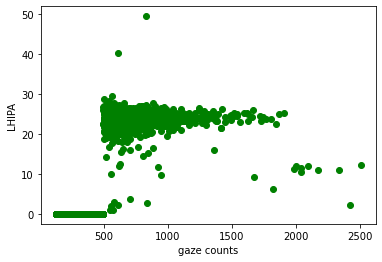

In [21]:
plt.scatter(ipa_df2['gaze_cnt'], ipa_df2['LHIPA'], c ="green")
plt.xlabel("gaze counts") #x label
plt.ylabel("LHIPA") #y label
plt.show()

In [22]:
ipa_df2.head()

,userid,claim_id,start_ts,end_ts,aoi,LHIPA,gaze_cnt
0,P001,A2002,1628616622147,1628616623377,fc_row_1_src_rep,0.000000,370
1,P001,A2002,1628616623413,1628616625236,fc_row_1_news_headline,24.136039,532
2,P001,A2002,1628616625923,1628616626563,fc_row_2_src_rep,0.000000,193
3,P001,A2002,1628616626980,1628616628643,fc_row_2_src_rep,0.000000,486
4,P001,A2002,1628616628689,1628616629573,fc_row_2_news_headline,0.000000,266


In [34]:
ipa_df2[ipa_df2['gaze_cnt']>500].count()

userid      1163
claim_id    1163
start_ts    1163
end_ts      1163
aoi         1163
LHIPA       1163
gaze_cnt    1163
dtype: int64

In [23]:
ipa_df_hdl = ipa_df2[ipa_df2['aoi'].str.contains('_headline')]
ipa_df_hdl.head()

,userid,claim_id,start_ts,end_ts,aoi,LHIPA,gaze_cnt
1,P001,A2002,1628616623413,1628616625236,fc_row_1_news_headline,24.136039,532
4,P001,A2002,1628616628689,1628616629573,fc_row_2_news_headline,0.000000,266
8,P001,A2002,1628616634109,1628616637338,fc_row_3_news_headline,23.536699,899
13,P001,A2002,1628616645624,1628616646777,fc_row_4_news_headline,0.000000,347
15,P001,A2002,1628616648240,1628616650553,fc_row_5_news_headline,24.210981,695


In [42]:
ipa_df_hdl['aoi'].value_counts()

fc_row_1_news_headline      1349
fc_row_2_news_headline      1067
fc_row_3_news_headline      1050
fc_row_4_news_headline      1002
fc_row_5_news_headline       996
fc_heading_news_headline      40
Name: aoi, dtype: int64

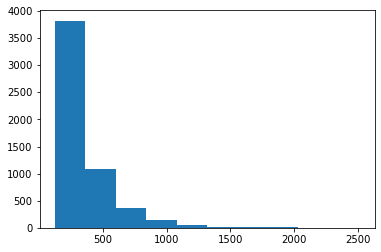

In [25]:
# plt.hist(ipa_df[ipa_df['LHIPA']>15]['gaze_cnt'])
plt.hist(ipa_df_hdl['gaze_cnt'])
plt.show()

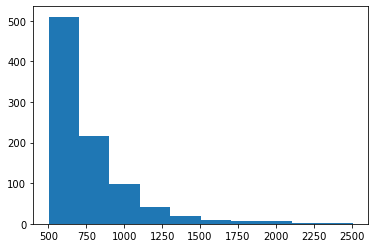

In [31]:
# plt.hist(ipa_df[ipa_df['LHIPA']>15]['gaze_cnt'])
plt.hist(ipa_hdl_v500['gaze_cnt'])
plt.show()

In [28]:
ipa_df_hdl[ipa_df_hdl['gaze_cnt']<=500].count()

userid      4595
claim_id    4595
start_ts    4595
end_ts      4595
aoi         4595
LHIPA       4595
gaze_cnt    4595
dtype: int64

In [29]:
ipa_hdl_v500 = ipa_df_hdl[ipa_df_hdl['gaze_cnt']>500]

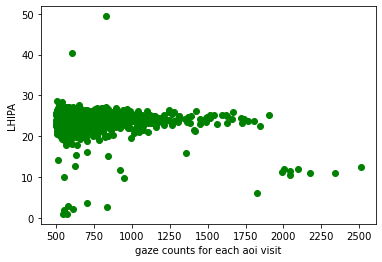

In [33]:
plt.scatter(ipa_hdl_v500['gaze_cnt'], ipa_hdl_v500['LHIPA'], c ="green")
plt.xlabel("gaze counts for each aoi visit") #x label
plt.ylabel("LHIPA") #y label
plt.show()

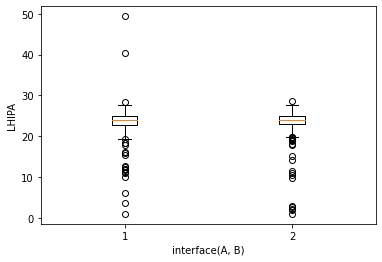

In [30]:
plt.boxplot([ipa_hdl_v500[ipa_hdl_v500['claim_id'].str.contains('A')]['LHIPA'],\
             ipa_hdl_v500[ipa_hdl_v500['claim_id'].str.contains('B')]['LHIPA']])
plt.ylabel("LHIPA") #y label
plt.xlabel("interface(A, B)")
plt.show()

In [40]:
ipa_df2.aoi.astype('category').cat.codes

0         9
1         6
2        13
3        13
4        10
         ..
10700     6
10701     6
10702     5
10703     4
10704     1
Length: 10705, dtype: int8

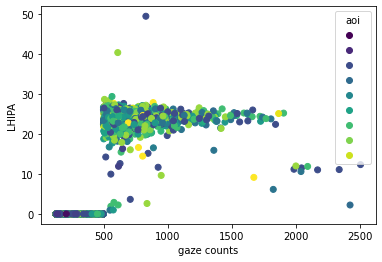

In [45]:
scatter = plt.scatter(x=ipa_df2['gaze_cnt'], y=ipa_df2['LHIPA'], c =ipa_df2.aoi.astype('category').cat.codes)
plt.xlabel("gaze counts") #x label
plt.ylabel("LHIPA") #y label
plt.legend(handles=scatter.legend_elements()[0],
           title="aoi")
plt.show()

In [52]:
ipa_df_hdl.head()

,userid,claim_id,start_ts,end_ts,aoi,LHIPA,gaze_cnt,ui
1,P001,A2002,1628616623413,1628616625236,fc_row_1_news_headline,24.136039,532,
4,P001,A2002,1628616628689,1628616629573,fc_row_2_news_headline,0.000000,266,A
8,P001,A2002,1628616634109,1628616637338,fc_row_3_news_headline,23.536699,899,
13,P001,A2002,1628616645624,1628616646777,fc_row_4_news_headline,0.000000,347,
15,P001,A2002,1628616648240,1628616650553,fc_row_5_news_headline,24.210981,695,A


In [55]:
for index, row in ipa_df_hdl.iterrows():
    ipa_df_hdl.loc[index, 'ui'] = row['claim_id'][0]
ipa_df_hdl.head(5)

/Users/lishi/miniforge3/envs/gsdata/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,userid,claim_id,start_ts,end_ts,aoi,LHIPA,gaze_cnt,ui,7
1,P001,A2002,1628616623413,1628616625236,fc_row_1_news_headline,24.136039,532,A,A
4,P001,A2002,1628616628689,1628616629573,fc_row_2_news_headline,0.000000,266,A,A
8,P001,A2002,1628616634109,1628616637338,fc_row_3_news_headline,23.536699,899,A,A
13,P001,A2002,1628616645624,1628616646777,fc_row_4_news_headline,0.000000,347,A,A
15,P001,A2002,1628616648240,1628616650553,fc_row_5_news_headline,24.210981,695,A,A


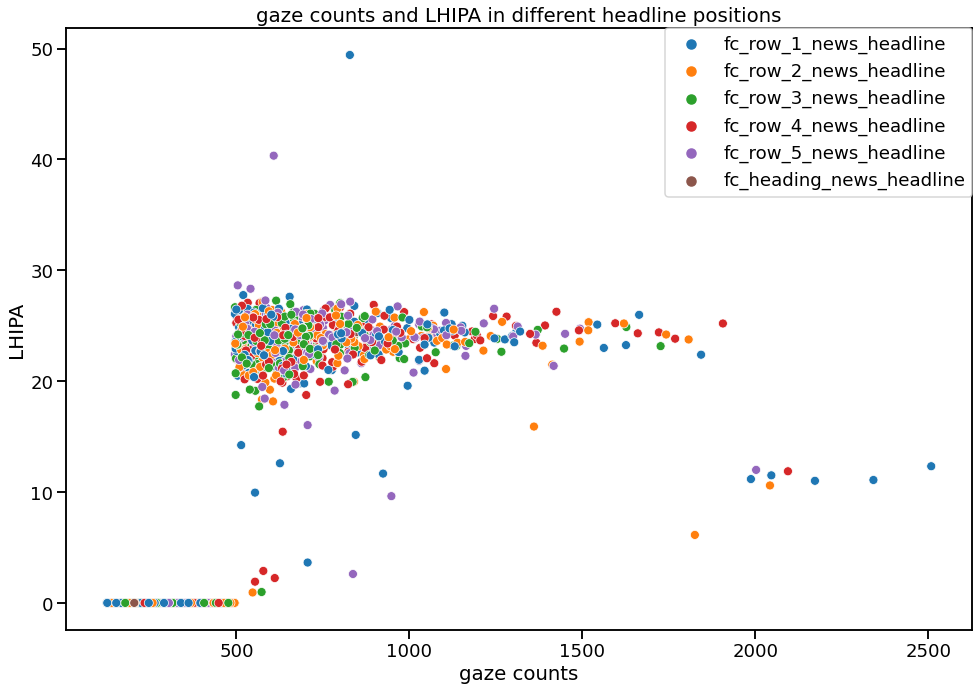

In [49]:
sns.set_context("talk", font_scale=1.1)
plt.figure(figsize=(14,10))
sns.scatterplot(x="gaze_cnt", 
                y="LHIPA", 
                hue="aoi",
                data=ipa_df_hdl)
plt.xlabel("gaze counts")
plt.ylabel("LHIPA")
# place the legend outside the figure/plot
plt.legend(bbox_to_anchor=(1, 1),
           borderaxespad=0)
plt.title("gaze counts and LHIPA in different headline positions")
plt.tight_layout()
# plt.savefig("place_legend_outside_plot_Seaborn_scatterplot.png",
#                     format='png',dpi=150)

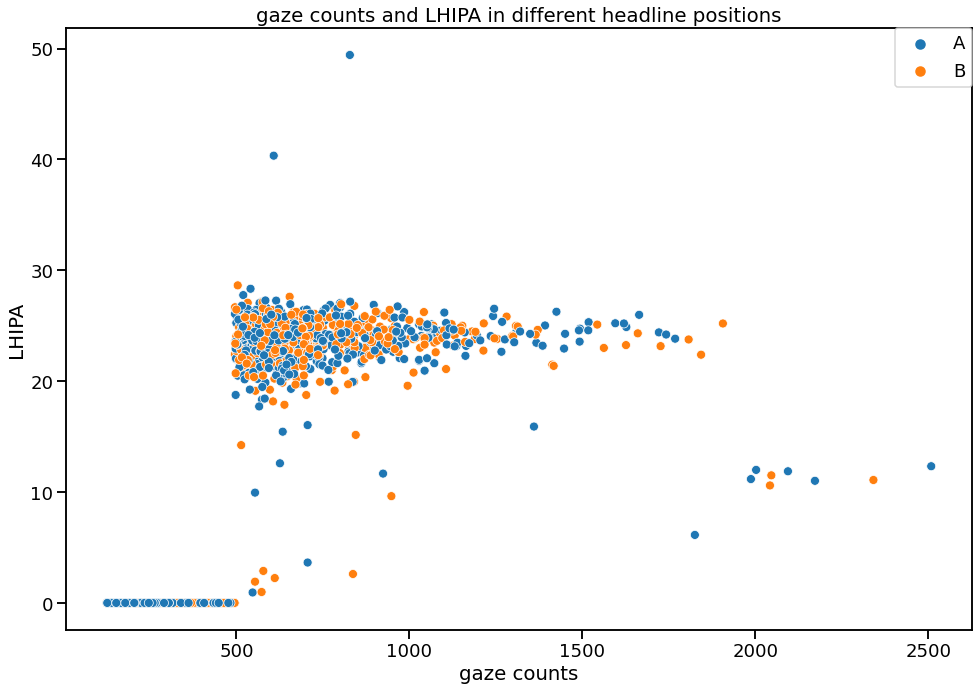

In [56]:
sns.set_context("talk", font_scale=1.1)
plt.figure(figsize=(14,10))
sns.scatterplot(x="gaze_cnt", 
                y="LHIPA", 
                hue="ui",
                data=ipa_df_hdl)
plt.xlabel("gaze counts")
plt.ylabel("LHIPA")
# place the legend outside the figure/plot
plt.legend(bbox_to_anchor=(1, 1),
           borderaxespad=0)
plt.title("gaze counts and LHIPA in different headline positions")
plt.tight_layout()
# plt.savefig("place_legend_outside_plot_Seaborn_scatterplot.png",
#                     format='png',dpi=150)

In [58]:
ipa_df_hdl[(ipa_df_hdl['gaze_cnt']<=500)&(ipa_df_hdl['ui']=='A')].count()

userid      2557
claim_id    2557
start_ts    2557
end_ts      2557
aoi         2557
LHIPA       2557
gaze_cnt    2557
ui          2557
7           2557
dtype: int64

In [35]:
ipa_hdl_i500 = ipa_df_hdl[ipa_df_hdl['gaze_cnt']<=500]